# AIsteroid
[http://bit.ly/aisteroid](http://bit.ly/aisteroid)

In [1]:
from aisteroid import *
%matplotlib nbagg

## Task: Detect and extract the sources in images

### Choose the image set

In [2]:
#listImages() ##See the list of imagesets
#CONF.SET="example" ##Choose your preferred imageset
#CONF.CFG="example" ##You choose your preferred observatory configuration (example.cfg)
#CONF.OVERWRITE=1 ##Overwrite all previous actions

#### DO NOT TOUCH IF YOU ARE NOT SURE

In [3]:
#DO NOT MODIFY THIS LINES
print0("*"*60+"\nSOURCES FOR SET '%s'\n"%CONF.SET+"*"*60)
OUT_DIR=CONF.SCR_DIR+CONF.SET+"/"
CFG=[line.rstrip('\n') for line in open(CONF.SETS_DIR+CONF.CFG+".cfg")]
AIA=dict()
AIA_FILE=OUT_DIR+CONF.SET+".aia"
SET_FILE=CONF.SETS_DIR+CONF.SET+".zip"
PLOT_DIR=OUT_DIR+"plots/"
if not os.path.isfile(AIA_FILE):
    error("Set '%s' has not been unpacked"%CONF.SET)
else:
    System("cp "+CONF.INPUT_DIR+"analysis/* "+OUT_DIR)
    AIA=pickle.load(open(AIA_FILE,"rb"))
    images=AIA["images"]
    nimgs=len(images)
    

************************************************************
SOURCES FOR SET 'example'
************************************************************


### Extract sources

In [4]:
print0("Extracting sources")

if not "sources" in AIA or CONF.OVERWRITE:
    sources=pd.DataFrame()
    for i,image in enumerate(images):
        file=image["file"]
        header=image["header"]

        #SEXtract
        print0("\tRunning SEXtractor over %s..."%file)
        output,header,data,nsources=SEXtract(OUT_DIR,file,DETECT_THRESH=CONF.DETECT_THRESH)
        hdul=fits.open(OUT_DIR+"%s.cat"%file)
        source=pd.DataFrame(hdul[1].data)
        hdul.close()
        print0("\t\t%d sources saved."%len(source))

        #Additional properties
        source["T"]=date2unix(image["obstime"])
        source["X_ALIGN"]=0.0
        source["Y_ALIGN"]=0.0

        #Astrometry
        source["RA"]=0.0
        source["DEC"]=0.0
        source["ERR_RA"]=0.0
        source["ERR_DEC"]=0.0

        #Alignment attributes
        source["IMG"]=i #In which image is this source
        source["STAR"]=0 #Is this a star?

        #Detection attributes
        source["OBJ"]=0 #To which object it belongs (detection procedure)
        source["NIMG"]=1 #In how many images is the object present (detection procedure)
        source["MOBJ"]=0 #To which moving object it belongs (detection procedure)

        #Photometric attributes
        source["MAG_ASTRO"]=0.0
        source["ERR_MAG_ASTRO"]=0.0

        sources=sources.append(source)

    sources.sort_values(by="MAG_BEST",ascending=True,inplace=True)
    sources.reset_index(inplace=True)

    AIA["sources"]=sources
    pickle.dump(AIA,open(AIA_FILE,"wb"))
else:
    print("Sources already detected.")
    AIA=pickle.load(open(AIA_FILE,"rb"))
    sources=AIA["sources"]
print0("\tTotal sources read: %d"%len(sources))    
print0("\tDone.")

Extracting sources
	Running SEXtractor over o8009g0075o.1299949.ch.1991737.XY51.p10...
		664 sources saved.
	Running SEXtractor over o8009g0096o.1299970.ch.1991758.XY51.p10...
		667 sources saved.
	Running SEXtractor over o8009g0117o.1299991.ch.1991779.XY51.p10...
		681 sources saved.
	Running SEXtractor over o8009g0138o.1300012.ch.1991800.XY51.p10...
		694 sources saved.
	Total sources read: 2706
	Done.


### Show sources

Showing sources
	Done.


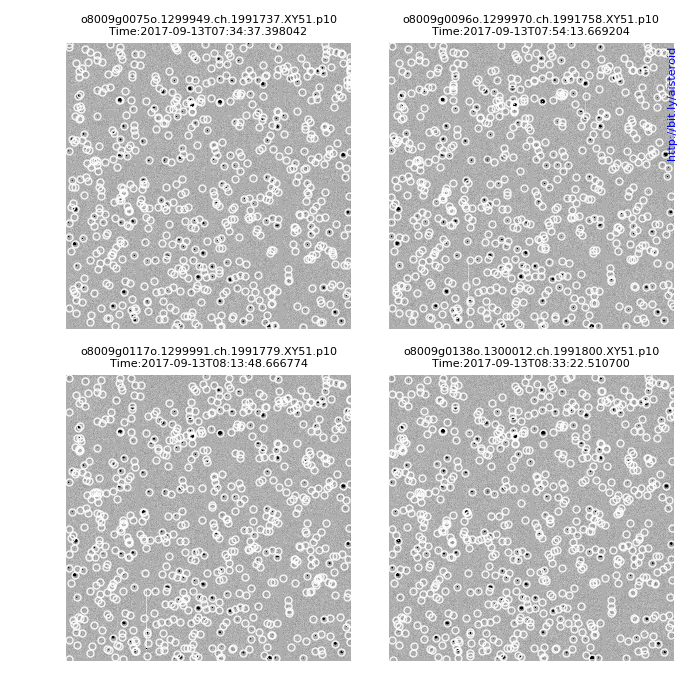

In [5]:
plotfile=PLOT_DIR+"sources-%s.png"%CONF.SET
if CONF.QPLOT:
    plt.ioff() ##Comment to see interactive figure
    
    if not os.path.isfile(plotfile) or CONF.OVERWRITE:

        print0("Showing sources")

        ncols=2
        nrows=int(nimgs/ncols)

        #Area of plotting
        fig,axs=plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(7,7))

        #Common options for plotting
        imgargs=dict(cmap='gray_r',vmin=0,vmax=500)

        for i,ax in enumerate(mat2lst(axs)):
            ax.imshow(images[i]["data"],**imgargs)
            source=sources[sources.IMG==i]
            ax.plot(source["X_IMAGE"]-1,source["Y_IMAGE"]-1,'wo',ms=5,mfc='None',alpha=0.9)
            ax.axis("off")
            otime=images[i]["header"]["DATE-OBS"]
            ax.set_title(images[i]["file"]+"\n"+"Time:"+otime,fontsize=8,position=(0.5,1.0))

        fig.tight_layout()
        waterMark(axs[0,1])
        fig.savefig(plotfile)
    else:
        if CONF.QPLOT:print0("Image '%s' already generated."%plotfile)
    print0("\tDone.")
Image(filename=plotfile)

### Align sources

In [6]:
print0("Finding alignment transformation")

if not "alignments" in AIA or CONF.OVERWRITE:
    print0("\tReference image:",images[0]["file"])
    
    #Reference image is not aligned
    sources.loc[sources.IMG==0,"X_ALIGN"]=sources[sources.IMG==0]["X_IMAGE"]
    sources.loc[sources.IMG==0,"Y_ALIGN"]=sources[sources.IMG==0]["Y_IMAGE"]

    columns=["X_IMAGE","Y_IMAGE"]
    alignments=[None]
    for i,image in enumerate(images[1:]):
        print0("\tAligning image:",images[i]["file"])
        imsources=sources[sources.IMG==(i+1)]

        #Measure initial misalignment
        ta,sa=matchSources(imsources[columns],
                           sources[sources.IMG==i][columns])
        mab=np.abs(sa-ta).mean()
        print1("\t\tAverage distance before alignment:",mab)

        #Align
        tr,(ta,sa)=forceAlignment(sources,i+1,i)
        alignments+=[tr]
        image["transform"]=tr

        #Measure misalignment after procedure
        sp=[]
        for j in range(ta.shape[0]):sp+=tr(ta[j,:]).tolist()
        sp=np.array(sp)
        maa=np.abs(sa-sp).mean()
        print1("\t\tAverage distance after alignment:",maa)
        print1("\t\tYou improved the alignment by a factor of ",mab/maa)

        #Align all coordinates
        xy=imsources[columns].values
        xya=[]
        for j in range(xy.shape[0]):
            xyr=xy[j,:]
            for ia in range(i+1,0,-1):
                #tr=images[ia]["transform"]
                tr=alignments[ia]
                xyr=tr(xyr).tolist()
            xya+=xyr
        xya=np.array(xya)
        imsources[["X_ALIGN","Y_ALIGN"]]=pd.DataFrame(xya,columns=["X_ALIGN","Y_ALIGN"],index=imsources.index)
        sources.loc[sources.IMG==(i+1),["X_ALIGN","Y_ALIGN"]]=imsources

        #Measure alignment
        print1("\t\tChecking alignment in the whole image:")

        ta,sa=matchSources(sources[sources.IMG==(i+1)],sources[sources.IMG==0])
        print1("\t\t\tAverage distance before alignment:",np.abs(sa-ta).mean())

        ta,sa=matchSources(pd.DataFrame(sources.loc[sources.IMG==(i+1),["X_ALIGN","Y_ALIGN"]].values,columns=columns),
                           pd.DataFrame(sources.loc[sources.IMG==0,["X_ALIGN","Y_ALIGN"]].values,columns=columns))
        print0("\t\t\tAverage distance after alignment:",np.abs(sa-ta).mean())
    
    AIA["alignments"]=sources
    pickle.dump(AIA,open(AIA_FILE,"wb"))
else:
    print("\tAlignment already computed.")
    AIA=pickle.load(open(AIA_FILE,"rb"))
    alignments=AIA["alignments"]

print("\tDone.")

Finding alignment transformation
	Reference image: o8009g0075o.1299949.ch.1991737.XY51.p10
	Aligning image: o8009g0075o.1299949.ch.1991737.XY51.p10
			Average distance after alignment: 0.596181858125
	Aligning image: o8009g0096o.1299970.ch.1991758.XY51.p10
			Average distance after alignment: 0.556800814224
	Aligning image: o8009g0117o.1299991.ch.1991779.XY51.p10
			Average distance after alignment: 0.56887514479
	Done.


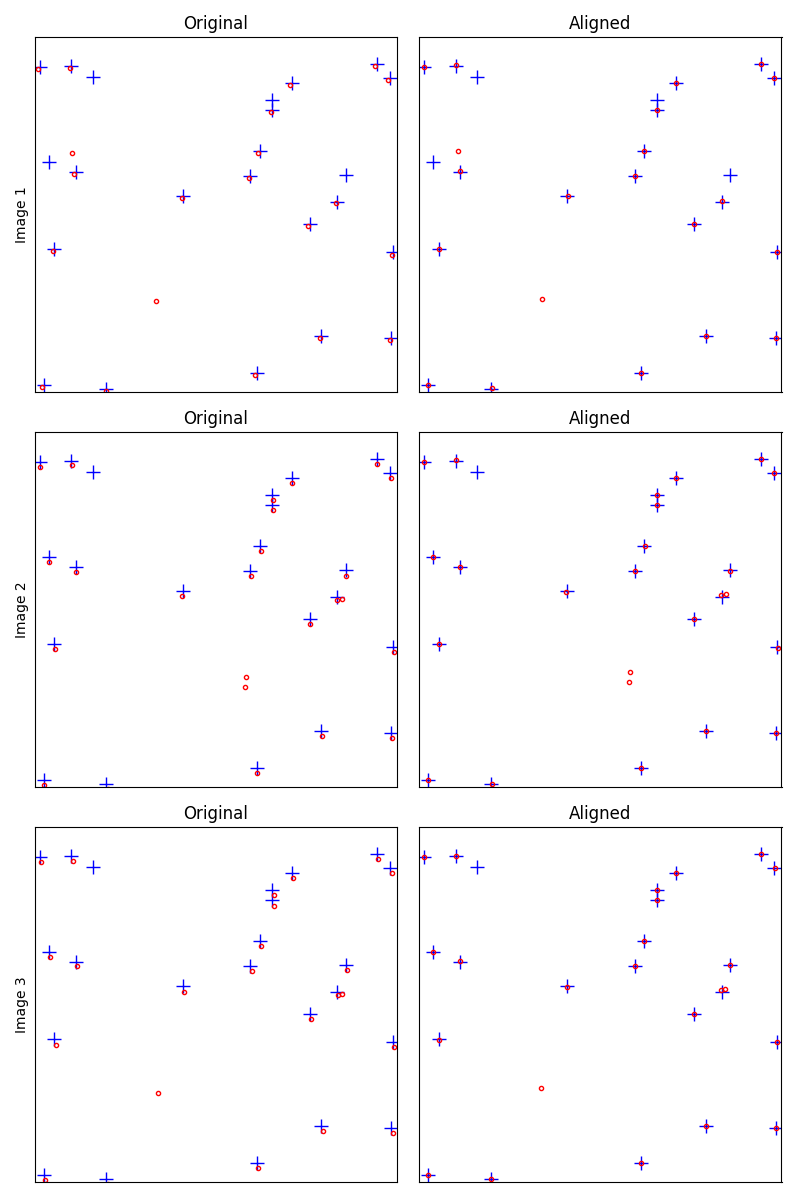

In [12]:
plotfile="%s/alignment-%s.png"%(PLOT_DIR,CONF.SET)
detector=AIA["detector"]

if CONF.QPLOT:
    plt.ioff() ##Comment to see interactive figure

    if (not os.path.isfile(plotfile) or CONF.OVERWRITE) and CONF.QPLOT:
        plt.ioff()
        fig,axs=plt.subplots(3,2,sharex=True,sharey=True,figsize=(8,12))

        dx=detector.SIZEX/10
        dy=detector.SIZEY/10

        #Show the misaligned sources
        images[0]["xy"]=sources.loc[sources.IMG==0,["X_IMAGE","Y_IMAGE"]].values
        images[0]["xy_aligned"]=sources.loc[sources.IMG==0,["X_ALIGN","Y_ALIGN"]].values
        for i,image in enumerate(images[1:]):
            iimg=i+1
            imsource=sources[sources.IMG==(i+1)]
            image["xy"]=imsource[["X_IMAGE","Y_IMAGE"]].values
            image["xy_aligned"]=imsource[["X_ALIGN","Y_ALIGN"]].values

            xcen=image["xy"][:,0].mean()
            ycen=image["xy"][:,1].mean()

            ax=axs[i,0]
            ax.plot(images[0]["xy"][:,0]-1,images[0]["xy"][:,1]-1,'b+',ms=10,mfc='None')
            ax.plot(image["xy"][:,0]-1,image["xy"][:,1]-1,'ro',ms=3,mfc='None')

            ax.set_title("Original")
            ax.set_ylabel("Image %d"%iimg)

            ax=axs[i,1]
            ax.set_title("Aligned")
            ax.plot(images[0]["xy_aligned"][:,0]-1,images[0]["xy_aligned"][:,1]-1,'b+',ms=10,mfc='None')
            ax.plot(image["xy_aligned"][:,0]-1,image["xy_aligned"][:,1]-1,'ro',ms=3,mfc='None')

        #Zoom in the center
        ax.set_xlim((xcen-dx,xcen+dx))
        ax.set_ylim((ycen-dy,ycen+dy))

        for ax in mat2lst(axs):
            ax.set_xticks([])
            ax.set_yticks([])

        fig.tight_layout()
        fig.savefig(plotfile)
else:
    if CONF.QPLOT:print0("Image '%s' already generated."%plotfile)
    print0("\tDone.")
Image(filename=plotfile)